In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import matplotlib.pyplot as plt 
from DCGAN import Generator, Discriminator, weights_init
import numpy as np
from tqdm.notebook import tqdm

In [2]:
## Import Dataset
img_size = 64
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])
mnist_data = torchvision.datasets.MNIST('/home/harsha/Deep Learning/Torchvision_Datasets', train=True, download=True, transform=transform)
mnist_data = DataLoader(mnist_data, batch_size = 64, shuffle = True)

tensor([5, 5, 0, 1, 5, 6, 9, 1, 8, 0, 6, 7, 5, 8, 7, 8, 9, 1, 0, 3, 4, 0, 2, 9,
        5])


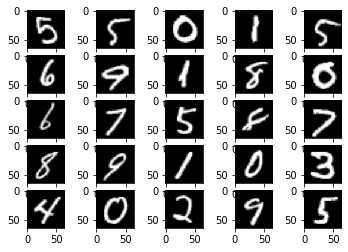

In [3]:
batch_idx, (example_data, example_targets) = next(enumerate(mnist_data))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(example_data[i][0].numpy(), cmap='gray', interpolation='none')
print(example_targets[:25])

In [4]:
## CUDA Devie Initialization
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Device Name:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

Device Name: GeForce GTX 1050 Ti


In [5]:
gen = Generator(100).to(device)
gen.apply(weights_init)
dis = Discriminator(1).to(device)
dis.apply(weights_init)

## Generator
print(gen)
## Discriminator
print(dis)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(16, 16), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(32, 32), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(64, 64), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ta

In [6]:
## Model Parameters
OPTIMIZER_GEN = Adam(gen.parameters(), lr = 0.0002, betas = (0.5, 0.99))
OPTIMIZER_DIS = Adam(dis.parameters(), lr = 0.0002, betas = (0.5, 0.99))
LOSS_CRITERION = nn.BCELoss()
EPOCHS = 10

In [10]:
noise = torch.randn(32,100,1,1).to(device)
for epoch in range(EPOCHS):
    
    epoch_loss = {'gen_loss':0, 'dis_loss':0}
    print('Epoch: {}'.format(epoch+1))
    
    for batch in tqdm(mnist_data):
        
        images,_ = batch
        images = images.to(device)
        
        ## Labels for Real Images
        target = torch.zeros(64, device = device)
        ## Predictions by Discriminator for Real Images
        dis.zero_grad()
        dis_out = dis(images).squeeze()
        print(dis_out)
        print(dis_out.shape)
        print(target.shape)
        
        dis_real_loss = LOSS_CRITERION(dis_out, target)
        dis_real_loss.backward()
        
        gen_fake_out = gen(noise)
        target.fill_(0)
        
        dis_out = dis(gen_fake_out.detach()).view(-1)
        dis_fake_loss = LOSS_CRITERION(dis_out, target)
        dis_real_loss.backward()
        
        epoch_loss['dis_loss'] += (dis_real_loss + dis_fake_loss).item()
        OPTIMIZER_DIS.step()
        
        gen.zero_grad()
        target.fill_(1)
        dis_out = dis(gen_fake_out).view(-1)
        gen_loss = LOSS_CRITERION(dis_out, target)
        gen_loss.backward()
        OPTIMIZER_GEN.step()
        
        epoch_loss['gen_loss'] += gen_loss.item()
    print('Generator Loss: {} | Discriminator Loss: {}'.format(epoch_loss['gen_loss'], epoch_loss['dis_loss']))
        
        
        

Epoch: 1


tensor([0.4354, 0.2609, 0.4890, 0.2361, 0.2276, 0.6230, 0.7325, 0.5226, 0.6340,
        0.4663, 0.5624, 0.3967, 0.3474, 0.5032, 0.7076, 0.2587, 0.9457, 0.3710,
        0.5852, 0.5659, 0.9479, 0.6440, 0.3104, 0.4508, 0.1549, 0.3072, 0.5939,
        0.5186, 0.2866, 0.7058, 0.6325, 0.7077, 0.7393, 0.5255, 0.6796, 0.3712,
        0.6552, 0.4875, 0.6575, 0.0383, 0.5612, 0.2348, 0.6153, 0.3801, 0.5425,
        0.7539, 0.2053, 0.3362, 0.8767, 0.4977, 0.6168, 0.5123, 0.3933, 0.2346,
        0.3158, 0.0895, 0.4650, 0.3474, 0.7598, 0.5580, 0.2730, 0.2130, 0.8124,
        0.9091], device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([64])
torch.Size([64])


ValueError: Target and input must have the same number of elements. target nelement (64) != input nelement (5408)